# Import packages

In [1]:
#pip install wikipedia
#pip install circlify
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import urllib
import re
import wikipedia
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import circlify
import plotly.graph_objects as go
import plotly.express as px
from nltk.cluster.util import cosine_distance
import networkx as nx
#nltk.download('stopwords')

# Text cleaning

In [2]:
# text extraction
wiki = wikipedia.page('Malnutrition')
text = wiki.content
# clean text
text_c = re.sub('[^A-Za-z0-9.]+', ' ', text) # match a single character not present in the list [^A-Za-z0-9.]
text_c = text_c.replace('\n', '').lower()
#text_c

# Wordcloud

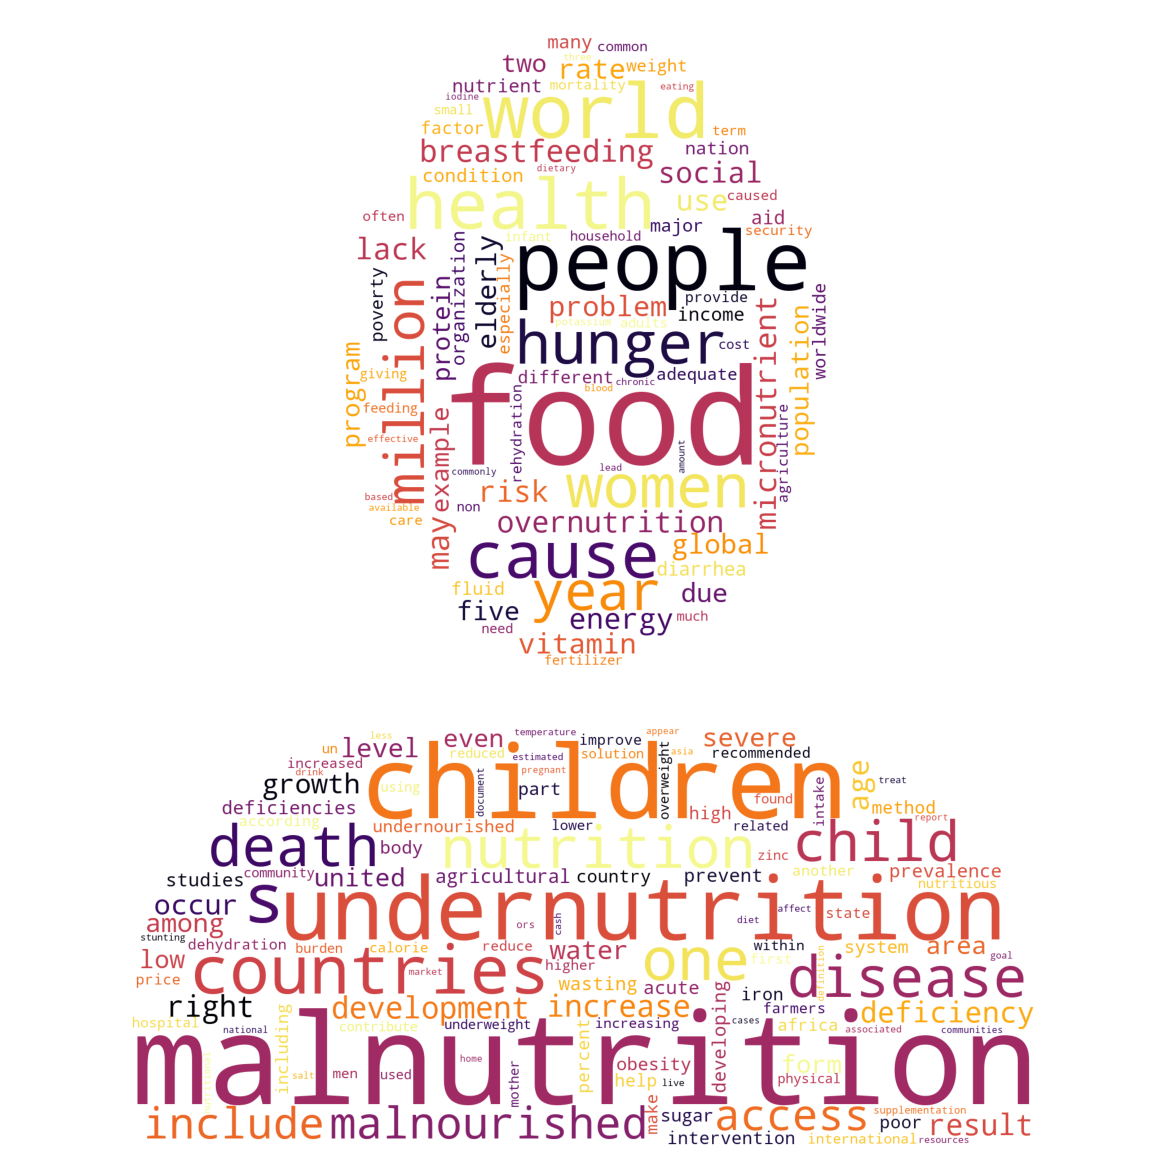

In [3]:
# import image to np.array
mask = np.array(Image.open('img/user.png'))
#STOPWORDS.add('one')

# generate wordcloud
wordcloud = WordCloud(width = 1000, height = 600, random_state=1, # max_words=100
                      background_color='white', colormap='inferno', # Set2
                      collocations=False, stopwords = STOPWORDS, # contour_width=1, contour_color='red'
                      mask=mask).generate(text_c)
# plot
plt.figure(figsize=(20, 15))
plt.imshow(wordcloud) 
plt.axis("off")
plt.show()
#plt.savefig('img/saved/wordcloud.jpeg')  

# Defining functions for further vizualisations

In [4]:
# defining stop words
stop_words = set(stopwords.words("english"))
for word in ['also', 'one', 'may', 'like', 'include', 'however', 'due', '.']:
    stop_words.add(word)

# create function to get a DataFrame
def get_df(input_text):
    list_words = input_text.split(' ')
    set_words_full = list(set(list_words))
    
    # remove stop words
    set_words = [i for i in set_words_full if i not in stop_words]
    
    # count each word
    count_words = [list_words.count(i) for i in set_words]
    
    # create DataFrame
    df = pd.DataFrame(zip(set_words, count_words), columns=['words','count'])
    df.sort_values('count', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# create function to get a color dictionary
def get_colordict(palette,number,start):
    pal = list(sns.color_palette(palette=palette, n_colors=number).as_hex())
    color_d = dict(enumerate(pal, start=start))
    return color_d

## Bubble chart

In [5]:
# clean text
#text_don = re.sub('[\d]+', '', text_c) #remove numbers
#text_don = text_don.replace('    ', '')
text_don = text_c.replace('.', '')
text_don = text_don.replace('  ', ' ')
#text_don

In [6]:
df_words = get_df(text_don)
#df_words.head(10)

In [7]:
# compute circle positions:
circles = circlify.circlify(df_words['count'][0:30].tolist(), 
                            show_enclosure=False, 
                            target_enclosure=circlify.Circle(x=0, y=0)
                           )
n = df_words['count'][0:30].max()
color_dict = get_colordict('RdYlBu_r',n ,1)

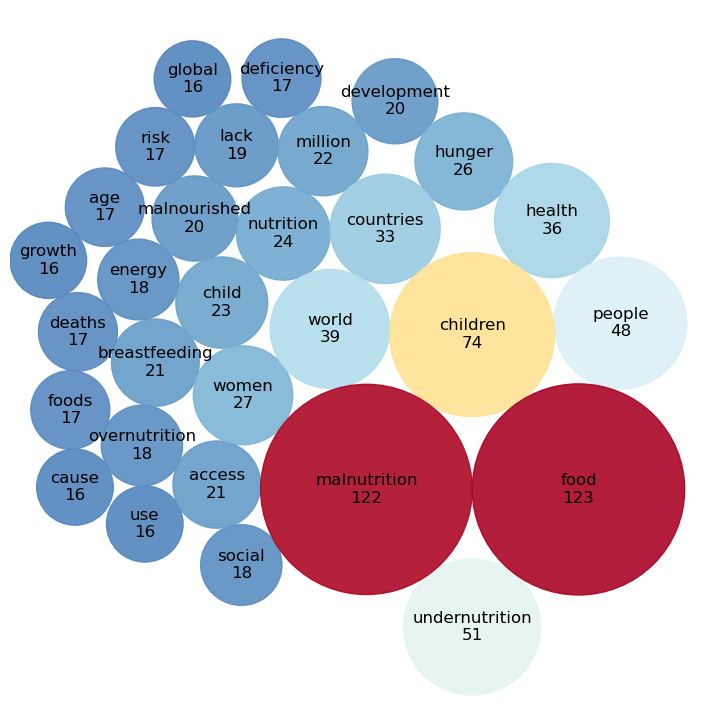

In [8]:
# visualisation
fig, ax = plt.subplots(figsize=(9,9), facecolor='white')
ax.axis('off')
lim = max(max(abs(circle.x)+circle.r, abs(circle.y)+circle.r,) for circle in circles)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# list of labels
labels = list(df_words['words'][0:30])
counts = list(df_words['count'][0:30])
labels.reverse()
counts.reverse()

# print circles
for circle, label, count in zip(circles, labels, counts):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.9, color = color_dict.get(count)))
    plt.annotate(label +'\n'+ str(count), (x,y), size=12, va='center', ha='center')
plt.xticks([])
plt.yticks([])
plt.show()

## Donut chart

In [9]:
# clean text
#text_don = re.sub('[\d]+', '', text_c) #remove numbers
#text_don = text_don.replace('    ', '')
text_don = text_c.replace('.', '')
text_don = text_don.replace('  ', ' ')
#text_don

In [10]:
df_words = get_df(text_don)
#df_words.head(12)

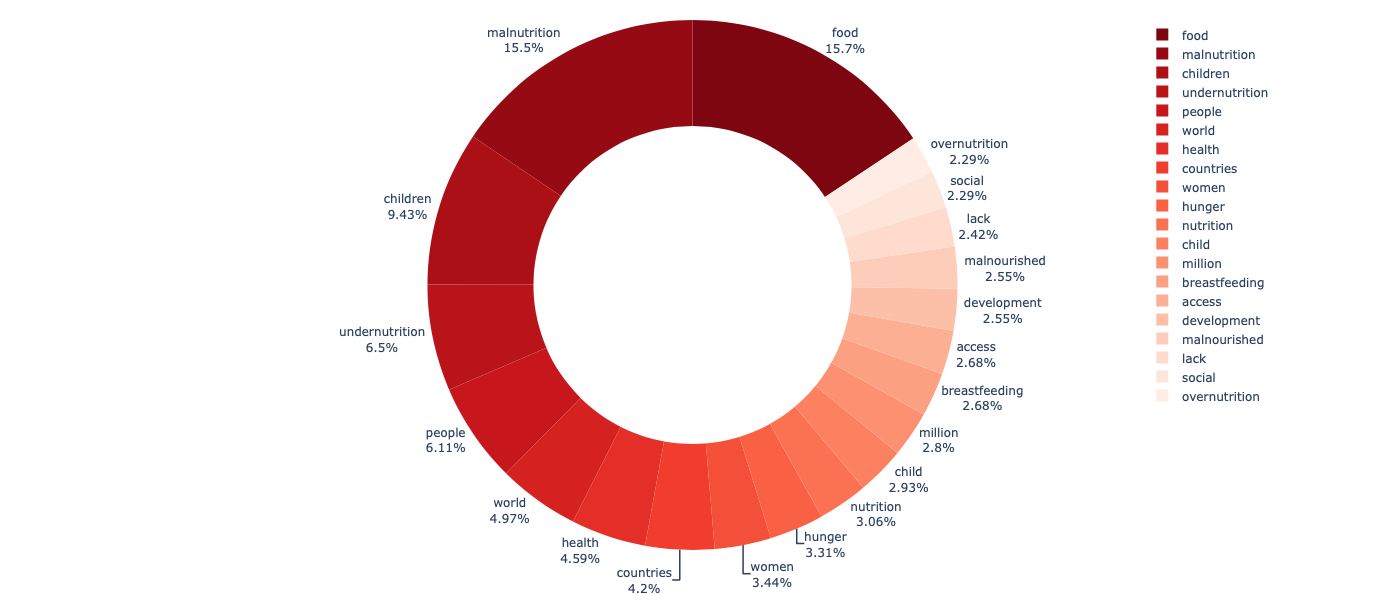

In [11]:
# visualisation
n = 20
pal = list(sns.color_palette(palette='Reds_r', n_colors=n).as_hex())
fig = px.pie(df_words[0:20], values='count', names='words',
             color_discrete_sequence=pal)
fig.update_traces(textposition='outside', textinfo='percent+label', 
                  hole=.6, hoverinfo="label+percent+name")
fig.update_layout(width = 1050, height = 600,
                  margin = dict(t=20, l=0, r=0, b=20))
fig.show()

## Defining functions to vizualize subparts

In [12]:
# manually create a list of contents
contents = ['Prevalence', 'Definitions',
            'Classifying malnutrition',
            'Effects','Causes & risk factors',
            'Prevention',
            'Treatment', 'Epidemiology',
            'History', 'Special populations','See also']

# slice text with content list
pr_text = []
for i in contents:
    idx1 = contents.index(i)
    if (idx1 >= 0) and (idx1 <= len(contents) - 2):
        text_s1 = text.split('\n\n\n== ' + i)[1] # should be 1
        text_s2 = text_s1.split('\n\n\n== ' + contents[idx1+1])[0]
        pr_text.append(text_s2)
    else:
        pass
#pr_text

In [13]:
# clean text in each content   
cn_clean_text = [re.sub('[^A-Za-z0-9]+', ' ', t).lower() for t in pr_text]

stop_words = set(stopwords.words("english"))
for word in ['also', 'one', 'may', 'like', 'include', 'however', 
             'due', 'five', 'among', '2020', '1', '5', 'two']:
    stop_words.add(word)


# create a DataFrame from top 10 words appearing in each content  
df_cn_words = [list(get_df(i)['words'][0:10]) for i in cn_clean_text if i not in stop_words]
df_cn_count = [list(get_df(i)['count'][0:10]) for i in cn_clean_text if i not in stop_words]
df_cn_content = [[i.lower()] * len(j) for i,j in zip(contents, df_cn_words)]

df_cont = pd.DataFrame(zip(sum(df_cn_content,[]), sum(df_cn_words,[]),sum(df_cn_count,[])),
                       columns = ['contents','words','count'])
df_cont

contents           words  count
0            prevalence        children     18
1            prevalence  undernutrition     15
2            prevalence          people      9
3            prevalence      prevalence      8
4            prevalence         million      7
..                  ...             ...    ...
95  special populations            food      9
96  special populations             men      9
97  special populations           rates      8
98  special populations       nutrition      8
99  special populations         percent      7

[100 rows x 3 columns]

In [14]:
# color dictionary
n = df_cont['count'].max()
color_dict = get_colordict('viridis', n , 1)

# create a list contains DataFrame of each content
keep_dfcon = [df_cont[df_cont['contents']==i.lower()] for i in contents[0:-1]]
num_w = len(keep_dfcon)

### Sunburst

In [15]:
# DataFrame summing words from each content 
df_sum = df_cont.groupby(['contents']).sum().reset_index()

# create a list for pre_words to use with plotly Sunburst Plot
pre_words = [i.split(' ')[0] for i in sum(df_cn_content,[])]
sb_words = [j+": "+i+' '+str(k) for i,j,k in zip(sum(df_cn_words,[]),
                                                pre_words,
                                                sum(df_cn_count,[]))] + list(df_sum['contents'])

sb_count = sum(df_cn_count,[]) + list(df_sum['count'])
sb_contents = sum(df_cn_content,[]) + ['Malnutrition']*len(list(df_sum['contents']))

In [16]:
# color dict for words
list_cn_count = sum(df_cn_count,[])
nc = max(list_cn_count) - min(list_cn_count) + 1
color_w = get_colordict('Reds', nc, min(list_cn_count))

# color dict for contents
list_sum_count = list(df_sum['count'])
nw = max(list_sum_count) - min(list_sum_count) + 1
color_c = get_colordict('Reds', nw, min(list_sum_count))

# create color list
sb_color=[color_w.get(i) for i in sum(df_cn_count,[])]+[color_c.get(i) for i in list(df_sum['count'])]

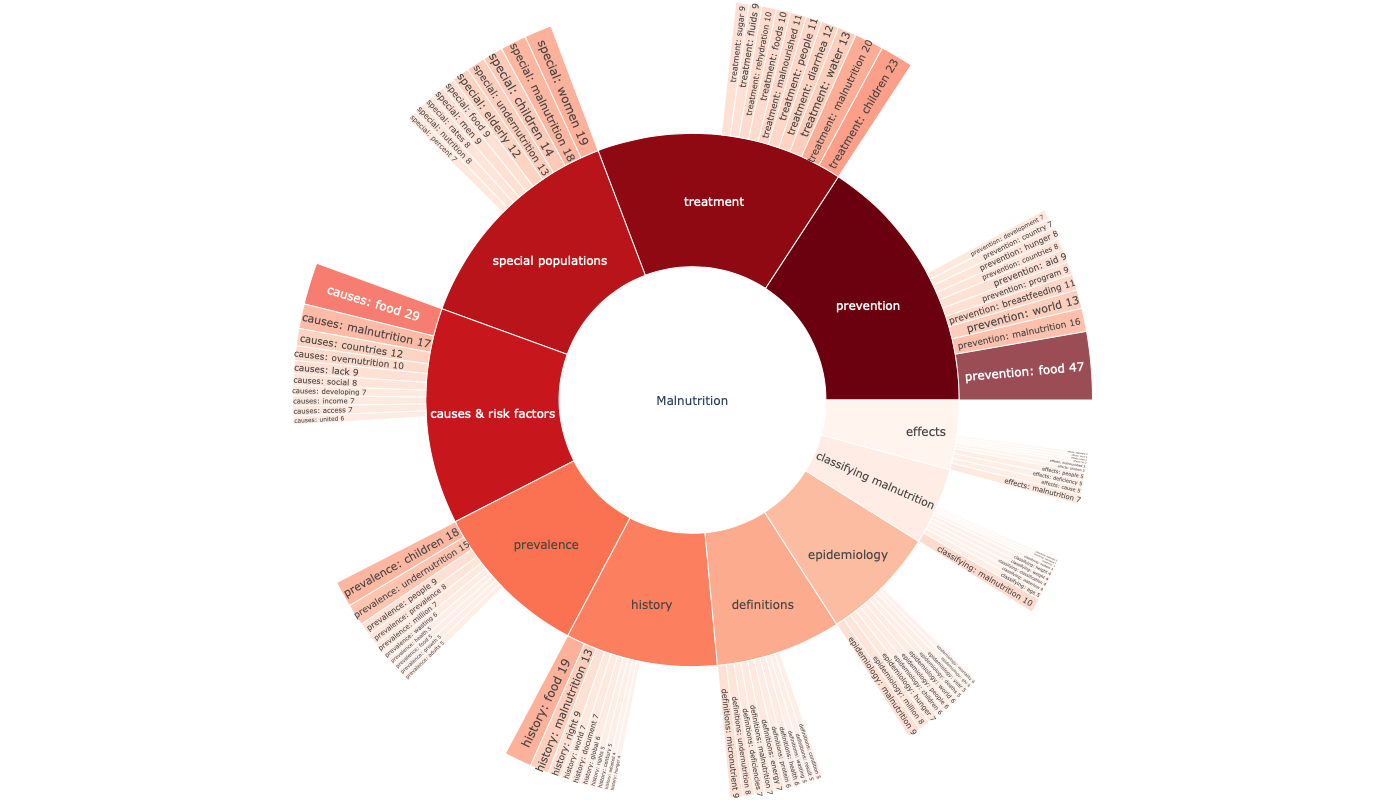

In [17]:
# visualisation
fig = go.Figure(go.Sunburst(labels = sb_words,
                            parents = sb_contents,
                            values = sb_count,
                            marker = dict(colors=sb_color)
                           ))
fig.update_layout(width=800, height=800,
                  margin = dict(t=0, l=0, r=0, b=0))
fig.show()

### Multiple bubble chart

In [18]:
# feature engineering
df_cont['topic'] = ['Malnutrition'] * len(df_cont)
df_cont = df_cont[['topic','contents','words','count']]

# adjust data format ('id', 'datum', 'children') to be used with circlify 
keep_sub = []
for ii in list(set(df_cont.iloc[:,1])):
    df_lv2 = df_cont[df_cont[df_cont.columns[1]] == ii]
    df_lv2_gb = df_cont.groupby([df_cont.columns[1]]).sum().reset_index()
    df_lv2_gbii = df_lv2_gb[df_lv2_gb['contents'] == ii]
    
    se_lv3 = [{'id':i,'datum':j} for i,j in zip(df_lv2['words'], df_lv2['count'])]
    dict_lv2_lv3 = {'id': df_lv2_gbii.iloc[0,0],'datum': df_lv2_gbii.iloc[0,1],'children': se_lv3}
    keep_sub.append(dict_lv2_lv3)
    
df_lv1_gb = df_cont.groupby([df_cont.columns[0]]).sum().reset_index()
data = [{'id': df_lv1_gb.iloc[0,0],'datum': df_lv1_gb.iloc[0,1],'children': keep_sub}]
#data

In [19]:
# defining circles
circles = circlify.circlify(data, 
                            show_enclosure=False, 
                            target_enclosure=circlify.Circle(x=0, y=0, r=1)
                           )
n = df_cont['count'].max()
color_dict_lv3 = get_colordict('autumn_r',n ,1) #RdYlBu_r, Spectral

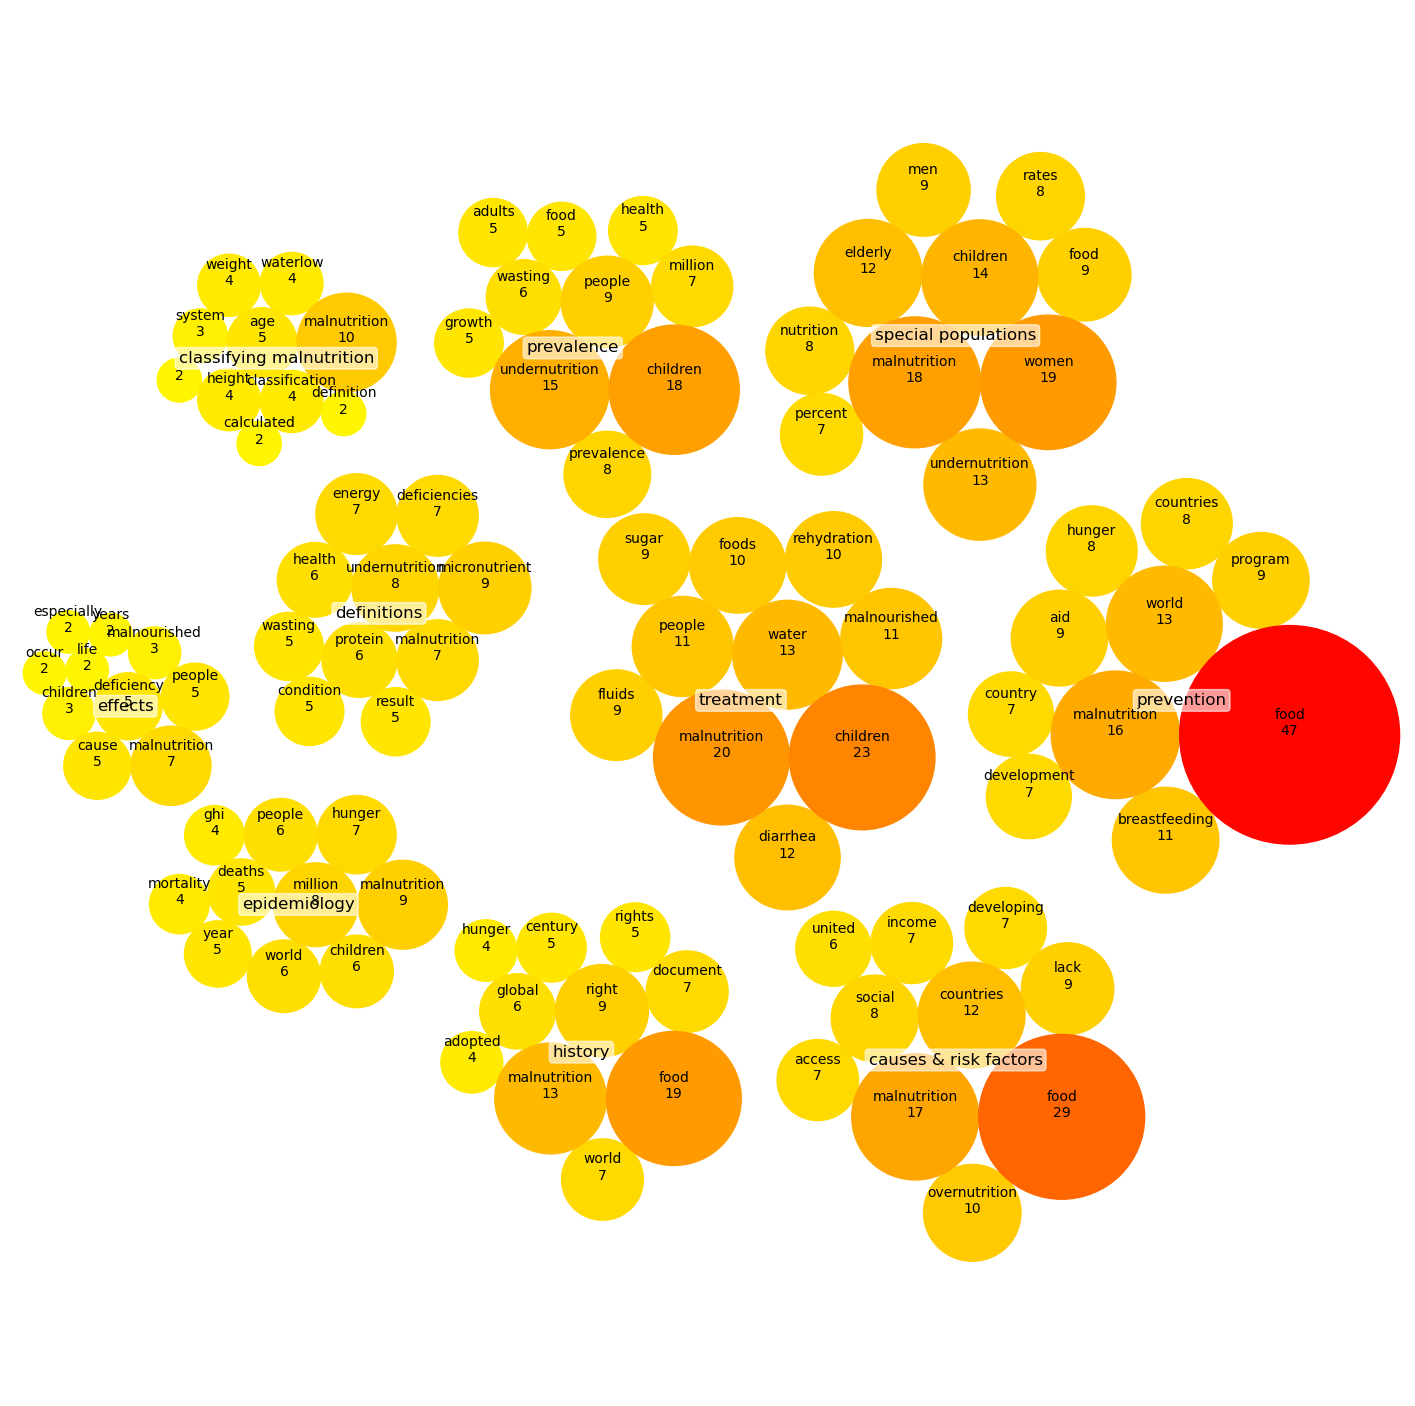

In [20]:
# visualisation
fig, ax = plt.subplots(figsize=(18,18), facecolor='white')
ax.axis('off')
# Find axis boundaries
lim = max(max(abs(circle.x) + circle.r,abs(circle.y) + circle.r,) for circle in circles)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# print circle and labels for the highest level (contents)
for circle in circles:
    if circle.level != 2:
      continue
    x, y, r = circle
    label = circle.ex["id"]
    ax.add_patch( plt.Circle((x, y), r, color="white"))
    plt.annotate(label, (x,y) ,va='center', ha='center', size=12, color="black",
                 bbox=dict(facecolor='white', edgecolor='white',
                           alpha=0.6, boxstyle='round', pad=.2)
                )
# print circle and labels for the highest level
for circle in circles:
    if circle.level != 3:
      continue
    x, y, r = circle
    label = circle.ex["id"]
    ax.add_patch( plt.Circle((x, y), r, color=color_dict_lv3.get(circle.ex['datum'])))
    #annotate each circle
    plt.annotate(label +'\n' +str(circle.ex['datum']), (x,y ), ha='center', color="black")

#plt.savefig('img/saved/multi_bubble.jpeg')  

# Summarization

In [21]:
# text from priorly cleaned 'text_c' file 
file_name = "src/malnutrition_wiki.txt"
file = open(file_name, "r")
filedata = file.readlines()
#filedata[0]

## Defining functions

In [22]:
# 1st function
def sentence_similarity(sent1, sent2, stopwords=None):
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
 
    all_words = list(set(sent1 + sent2))
 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
 
    return 1 - cosine_distance(vector1, vector2)

In [23]:
# 2nd function using the 1st one
def build_similarity_matrix(sentences, stop_words):
    # create an empty similarity matrix
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
 
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2: # ignore if both are same sentences
                continue 
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)

    return similarity_matrix

In [24]:
# 3rd function
def read_sentences(file_name):
    file = open(file_name, "r")
    filedata = file.readlines()
    article = filedata[0].split(". ")
    sentences = []

    for sentence in article:
        #print(sentence)
        sentences.append(sentence.replace("[^a-zA-Z]", " ").split(" "))
    #sentences.pop() 
    
    return sentences

## Summarizing

In [25]:
# use of the read_sentences function to check the given text
read_sentences("src/malnutrition_wiki.txt")[0:3]

[['malnutrition',
  'or',
  'nutritional',
  'deficiency',
  'occurs',
  'when',
  'an',
  'organism',
  'gets',
  'too',
  'few',
  'or',
  'too',
  'many',
  'nutrients',
  'resulting',
  'in',
  'health',
  'problems'],
 ['specifically',
  'it',
  'is',
  'a',
  'deficiency',
  'excess',
  'or',
  'imbalance',
  'of',
  'energy',
  'protein',
  'and',
  'other',
  'nutrients',
  'which',
  'adversely',
  'affects',
  'the',
  'body',
  's',
  'tissues',
  'and',
  'form'],
 ['malnutrition',
  'is',
  'not',
  'receiving',
  'the',
  'correct',
  'amount',
  'of',
  'nutrition']]

In [26]:
# starting the process of summarization
stop_words = stopwords.words('english')
summarize_text = []

# step 1 - read text and split it
sentences =  read_sentences(file_name)

# step 2 - generate similary matrix across sentences
sentence_similarity_matrix = build_similarity_matrix(sentences, stop_words)

# step 3 - rank sentences in similarity matrix
sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_matrix)
scores = nx.pagerank(sentence_similarity_graph)

# step 4 - sort the rank and pick top sentences
ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)    
print("\nIndexes of top ranked_sentence order are: \n\n", ranked_sentence[0:11])    

for i in range(10):
    summarize_text.append(" ".join(ranked_sentence[i][1]))


Indexes of top ranked_sentence order are: 

 [(0.005380924469096643, ['the', 'right', 'to', 'food', 'is', 'a', 'human', 'right', 'for', 'people', 'to', 'feed', 'themselves', 'in', 'dignity', 'be', 'free', 'from', 'hunger', 'food', 'insecurity', 'and', 'malnutrition']), (0.005361169127992874, ['food', 'banks', 'and', 'soup', 'kitchens', 'address', 'malnutrition', 'in', 'places', 'where', 'people', 'lack', 'money', 'to', 'buy', 'food']), (0.005118445500209676, ['however', 'in', 'the', 'developing', 'world', 'eighty', 'percent', 'of', 'malnourished', 'children', 'live', 'in', 'countries', 'that', 'produce', 'food', 'surpluses', 'according', 'to', 'estimates', 'from', 'the', 'food', 'and', 'agriculture', 'organization', 'fao', '']), (0.004861015039588904, ['a', 'later', 'document', 'in', 'the', 'timeline', 'of', 'global', 'inititaves', 'for', 'malnutrition', 'was', 'the', '1996', 'rome', 'declaration', 'on', 'world', 'food', 'security', 'organized', 'by', 'the', 'food', 'and', 'agricultur

## Final result

In [27]:
# step 5 - output the summarize text
print("\nSummarize Text: \n", ". ".join(summarize_text))


Summarize Text: 
 the right to food is a human right for people to feed themselves in dignity be free from hunger food insecurity and malnutrition. food banks and soup kitchens address malnutrition in places where people lack money to buy food. however in the developing world eighty percent of malnourished children live in countries that produce food surpluses according to estimates from the food and agriculture organization fao . a later document in the timeline of global inititaves for malnutrition was the 1996 rome declaration on world food security organized by the food and agriculture organization. however the use of malnutrition instead of undernutrition makes it impossible to distinguish between undernutrition and overnutrition a less acknowledged form of malnutrition. in 2010 malnutrition caused about 1.5 million deaths in women and children.according to the world health organization malnutrition is the biggest contributor to child mortality present in half of all cases. extre